In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
from datetime import datetime


In [32]:
df = pd.read_csv('Realisierter_Stromverbrauch_201501010000_202412020000_Viertelstunde.csv',sep=';')

In [50]:
df.max()

Datum von                                 2024-12-01 23:45:00
Datum bis                                    31.12.2023 23:45
Netzlast                                              20403.5
Residuallast [MWh] Originalauflösungen                 999,75
Pumpspeicher [MWh] Originalauflösungen                 999,75
Hour                                                       23
Month                                                      12
Year                                                     2024
DayOfWeek                                                   6
DayOfMonth                                                 31
dtype: object

In [34]:
# Preprocessing
df['Datum von'] = pd.to_datetime(df['Datum von'], format='%d.%m.%Y %H:%M')
df['Gesamt (Netzlast) [MWh] Originalauflösungen'] = df['Gesamt (Netzlast) [MWh] Originalauflösungen'].str.replace('.', '').str.replace(',', '.').astype(float)

# Rename column for simplicity
df.rename(columns={'Gesamt (Netzlast) [MWh] Originalauflösungen': 'Netzlast'}, inplace=True)

# Extract relevant features
df['Hour'] = df['Datum von'].dt.hour  # For daily average
df['Month'] = df['Datum von'].dt.month  # For monthly average
df['Year'] = df['Datum von'].dt.year  # For yearly trend
df['DayOfWeek'] = df['Datum von'].dt.dayofweek 
df['DayOfMonth'] = df['Datum von'].dt.day


# Group for daily, monthly, and yearly averages
daily_avg = df.groupby('Hour')['Netzlast'].mean()
weekly_avg = df.groupby('DayOfWeek')['Netzlast'].mean()
monthly_day_avg = df.groupby('DayOfMonth')['Netzlast'].mean()
monthly_avg = df.groupby('Month')['Netzlast'].mean()
yearly_avg = df.groupby('Year')['Netzlast'].mean()

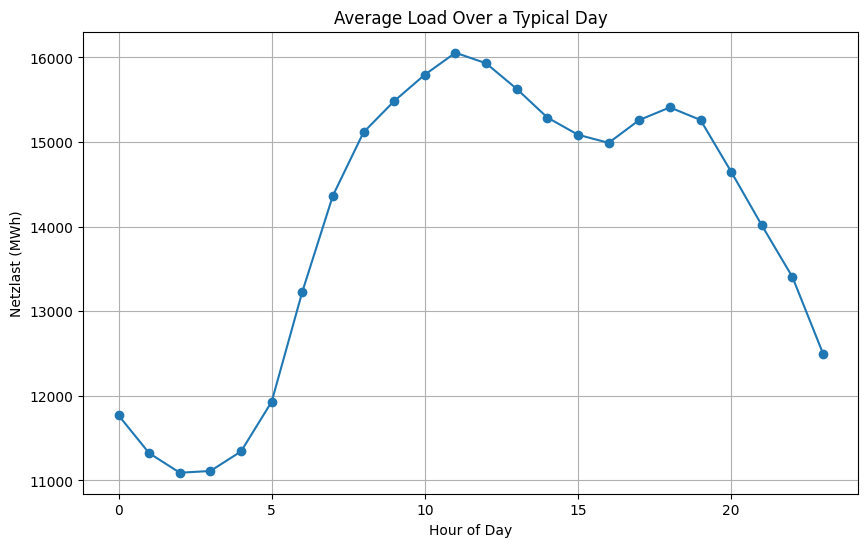

In [35]:
# Plot the typical day
plt.figure(figsize=(10, 6))
plt.plot(daily_avg.index, daily_avg, marker='o')
plt.title('Average Load Over a Typical Day')
plt.xlabel('Hour of Day')
plt.ylabel('Netzlast (MWh)')
plt.grid()
plt.show()

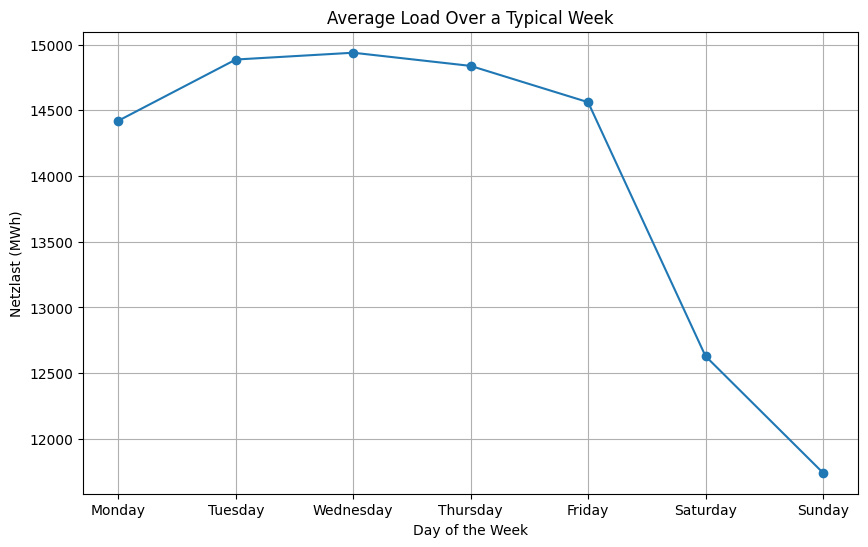

In [36]:
# Plot the typical week
plt.figure(figsize=(10, 6))
plt.plot(weekly_avg.index, weekly_avg, marker='o')
plt.title('Average Load Over a Typical Week')
plt.xlabel('Day of the Week')
plt.ylabel('Netzlast (MWh)')
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.grid()
plt.show()

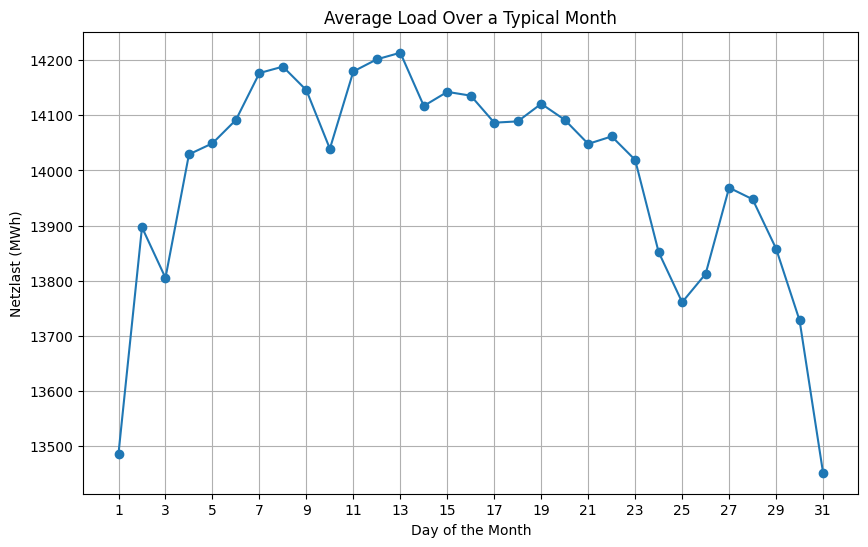

In [38]:
# Plot the typical month
plt.figure(figsize=(10, 6))
plt.plot(monthly_day_avg.index, monthly_day_avg, marker='o')
plt.title('Average Load Over a Typical Month')
plt.xlabel('Day of the Month')
plt.ylabel('Netzlast (MWh)')
plt.xticks(ticks=range(1, 32, 2))  # Show ticks every 2 days for readability
plt.grid()
plt.show()

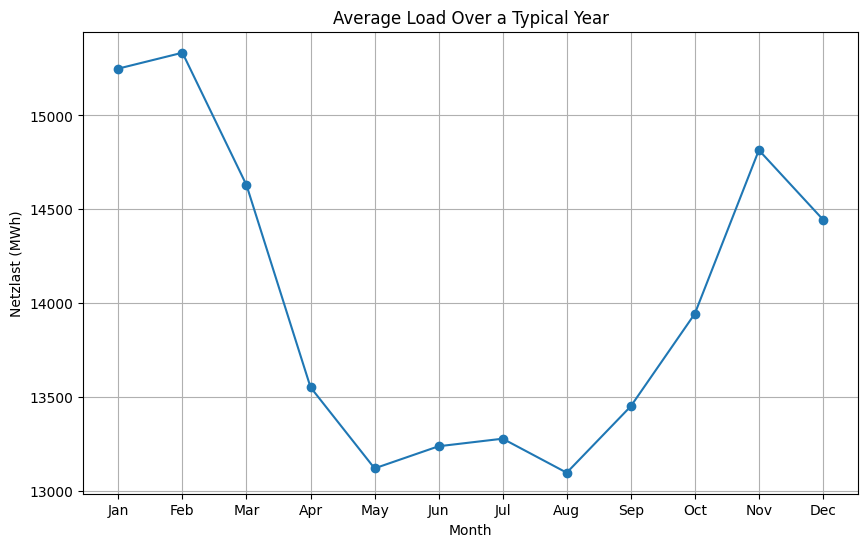

In [39]:
# Plot the typical month
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg.index, monthly_avg, marker='o')
plt.title('Average Load Over a Typical Year')
plt.xlabel('Month')
plt.ylabel('Netzlast (MWh)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid()
plt.show()

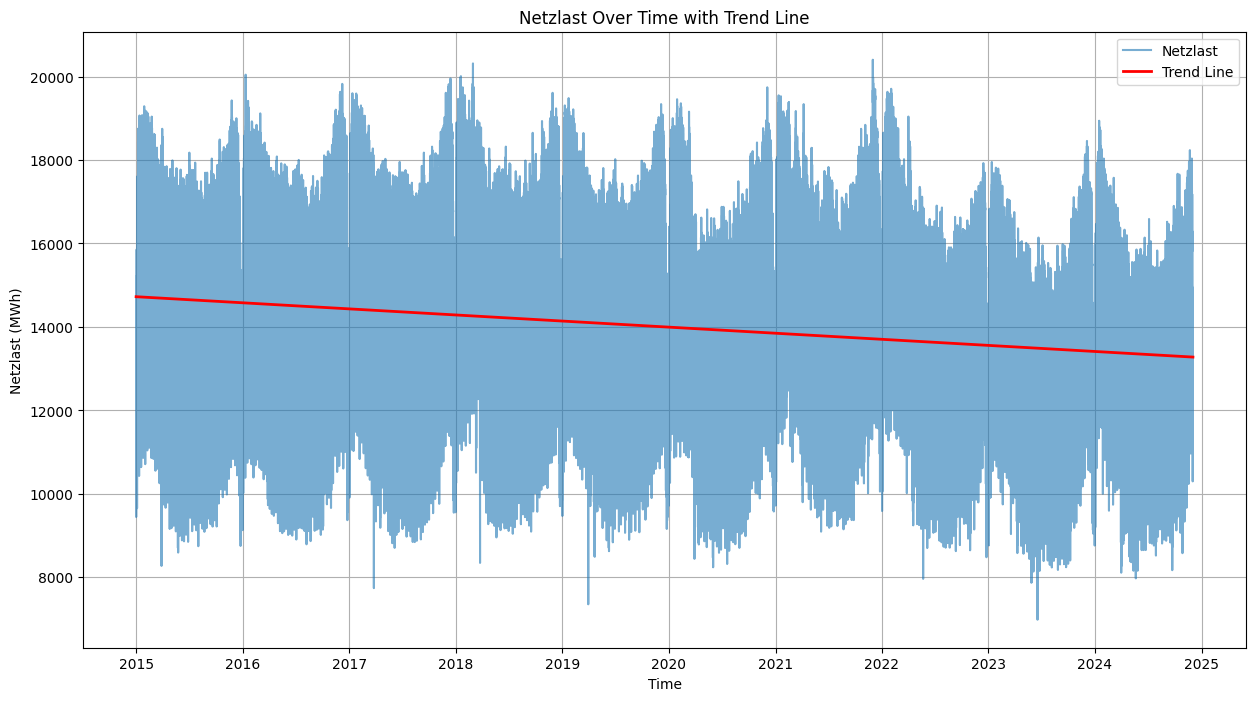

In [49]:
# Plot all the data
plt.figure(figsize=(15, 8))
plt.plot(df['Datum von'], df['Netzlast'], label='Netzlast', alpha=0.6)

# Convert datetime to ordinal values (numeric values for linear regression)
x = df['Datum von'].map(datetime.timestamp).values.reshape(-1, 1)
y = df['Netzlast'].values

# Fit a linear regression model
model = LinearRegression()
model.fit(x, y)

# Predict the trend line
trend_line = model.predict(x)

# Plot the trend line
plt.plot(df['Datum von'], trend_line, color='red', label='Trend Line', linewidth=2)

# Add titles and labels
plt.title('Netzlast Over Time with Trend Line')
plt.xlabel('Time')
plt.ylabel('Netzlast (MWh)')
plt.legend()
plt.grid()
plt.show()